# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix

# Loading the training CSV file

In [2]:
train_csv_loc = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
train_csv = pd.read_csv(train_csv_loc)
train_csv

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


# Loading the prompts CSV files

In [3]:
prompts_csv = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
pd.read_csv(prompts_csv)

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


# Analyzing test dataset

generated
0    1375
1       3
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x7e0a7ada94e0>,
 [Text(-1.0999742722741532, 0.0075233194101512945, 'generated by students'),
  Text(1.099974272477764, -0.007523289640464896, 'generated by LLM')],
 [Text(-0.5999859666949926, 0.004103628769173433, '99.78%'),
  Text(0.599985966806053, -0.00410361253116267, '0.22%')])

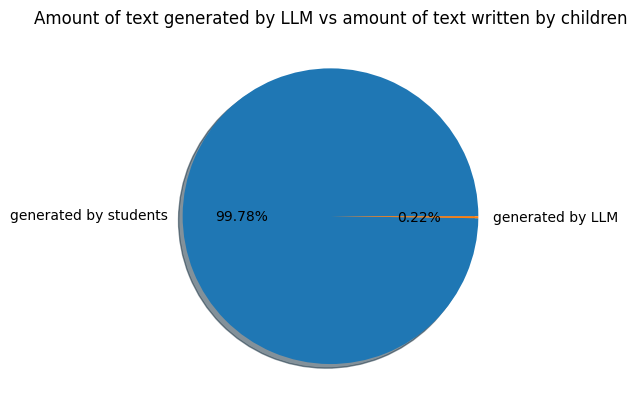

In [4]:
llm_gen_perc = train_csv.groupby('generated').count()['text']
print(llm_gen_perc)
plt.title("Amount of text generated by LLM vs amount of text written by children")
plt.pie(llm_gen_perc,labels=['generated by students','generated by LLM'],autopct = '%0.2f%%',shadow=True)

Only 3 out of 1378 entries are generated by LLM accounting for mere 0.2%. This is an extreme class imbalance.

prompt_id
0    708
1    670
Name: generated, dtype: int64


([<matplotlib.patches.Wedge at 0x7e0a78c5ea10>,
 [Text(-0.04763336781987195, 1.0989681807359741, 'Car-free cities'),
  Text(0.047633367819872305, -1.0989681807359741, 'Does the electoral college work?')],
 [Text(-0.025981836992657426, 0.5994371894923495, '51.38%'),
  Text(0.025981836992657617, -0.5994371894923495, '48.62%')])

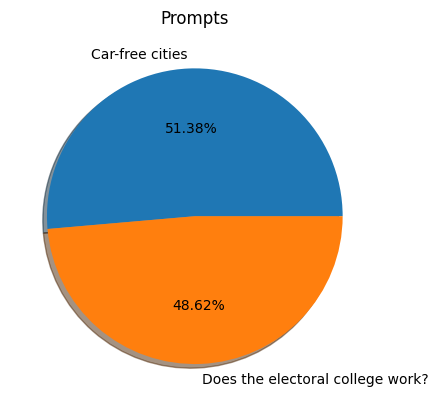

In [5]:
prompt_perc = train_csv.groupby('prompt_id').count()['generated']
print(prompt_perc)
plt.title("Prompts")
plt.pie(prompt_perc,labels=["Car-free cities","Does the electoral college work?"],autopct="%0.2f%%",shadow=True)

# Adding new data to prevent class imbalance

In [6]:
dataset_1_loc ='/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v6.csv'
aug_data1 = pd.read_csv(dataset_1_loc)
aug_data1 = aug_data1[aug_data1["prompt_id"]==2]
aug_data1["prompt_id"]=aug_data1['prompt_id']-2
aug_data1

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4195,0,The concept of car-free cities is becoming in...,Car-free cities,1
4196,0,Car-free cities: a vision for a healthier and...,Car-free cities,1
4197,0,The concept of car-free cities has gained pop...,Car-free cities,1
4198,0,Car-free cities are cities where cars are not...,Car-free cities,1


In [7]:
dataset_2_loc = '/kaggle/input/llm-mistral-7b-instruct-texts/Mistral7B_CME_v7.csv'
aug_data2 = pd.read_csv(dataset_2_loc)
aug_data2 = aug_data2[aug_data2["prompt_id"]==12]
aug_data2["prompt_id"]=aug_data2['prompt_id']-11
aug_data2

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [8]:
aug_data_mistral = pd.concat([aug_data1,aug_data2],axis=0)
aug_data_mistral

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


The new dataset has both prompts 50% each and all 1400 entries being AI generated compared to 1378 entries of original dataset with only 3 AI generated texts. So, it will be good to concatenate both datasets.
For this , we have to remove columns which are different in both datasets.

In [9]:
aug_data_mistral = aug_data_mistral.drop(columns= ['prompt_name'])
aug_data_mistral

,prompt_id,text,generated
3500,0,Car-free cities are becoming increasingly pop...,1
3501,0,Car-free cities are becoming increasingly pop...,1
3502,0,Car-free cities are becoming increasingly pop...,1
3503,0,Car-free cities have become increasingly popu...,1
3504,0,Car-free cities are a growing concept in toda...,1
...,...,...,...
4895,1,The electoral college is one of the most disc...,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,1,The electoral college is a system that is use...,1
4898,1,A strong electoral system is vital to the fun...,1


Dropped prompt name column as it was unnecessary because prompt Id is already given.

In [10]:
train_csv= train_csv.drop(columns=['id'])
train_csv

,prompt_id,text,generated
0,0,Cars. Cars have been around since they became ...,0
1,0,Transportation is a large necessity in most co...,0
2,0,"""America's love affair with it's vehicles seem...",0
3,0,How often do you ride in a car? Do you drive a...,0
4,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...
1373,1,There has been a fuss about the Elector Colleg...,0
1374,0,Limiting car usage has many advantages. Such a...,0
1375,0,There's a new trend that has been developing f...,0
1376,0,As we all know cars are a big part of our soci...,0


Dropped id column as it is not necessary for training and also to concatenate with new dataset

# Final dataset to be used

In [11]:
final_data = pd.concat([train_csv,aug_data_mistral],axis=0)
final_data

,prompt_id,text,generated
0,0,Cars. Cars have been around since they became ...,0
1,0,Transportation is a large necessity in most co...,0
2,0,"""America's love affair with it's vehicles seem...",0
3,0,How often do you ride in a car? Do you drive a...,0
4,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...
4895,1,The electoral college is one of the most disc...,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,1,The electoral college is a system that is use...,1
4898,1,A strong electoral system is vital to the fun...,1


([<matplotlib.patches.Wedge at 0x7e0a78cd3ca0>,
 [Text(0.017414888503137493, 1.0998621375692608, 'generated by AI'),
  Text(-0.017414991479663147, -1.0998621359387564, 'not generated by AI')],
 [Text(0.00949903009262045, 0.5999248023105058, '49.50%'),
  Text(-0.009499086261634442, -0.5999248014211398, '50.50%')])

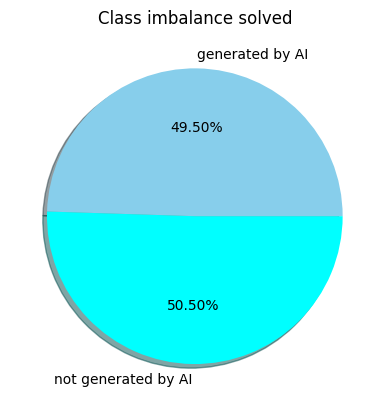

In [12]:
classes = final_data.groupby('generated').count()['text']
plt.title('Class imbalance solved')
plt.pie(classes, labels=['generated by AI','not generated by AI'],colors=['skyblue','cyan'],shadow=True,autopct='%0.2f%%')

prompt_id
0    1408
1    1370
Name: generated, dtype: int64


([<matplotlib.patches.Wedge at 0x7e0a78b37520>,
 [Text(-0.02363363825228276, 1.0997460848500258, 'Car-free cities'),
  Text(0.023633638252282377, -1.0997460848500258, 'Does the electoral college work?')],
 [Text(-0.012891075410336048, 0.5998615008272867, '50.68%'),
  Text(0.01289107541033584, -0.5998615008272867, '49.32%')])

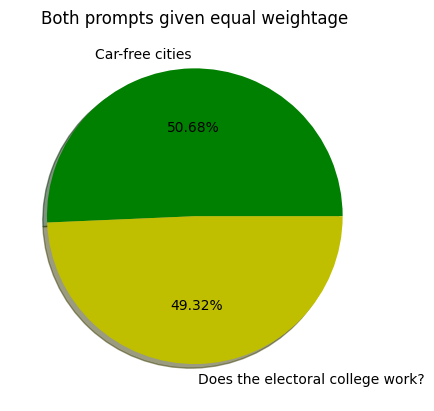

In [13]:
prompts_final = final_data.groupby('prompt_id').count()['generated']
print(prompts_final)
plt.title('Both prompts given equal weightage')
plt.pie(prompts_final, labels=['Car-free cities','Does the electoral college work?'],colors=['g','y'], shadow=True,autopct='%0.2f%%')

Final dataset is completed and ready to work on

# Cleaning the dataset

In [14]:
x = final_data.iloc[:,:2]
x

,prompt_id,text
0,0,Cars. Cars have been around since they became ...
1,0,Transportation is a large necessity in most co...
2,0,"""America's love affair with it's vehicles seem..."
3,0,How often do you ride in a car? Do you drive a...
4,0,Cars are a wonderful thing. They are perhaps o...
...,...,...
4895,1,The electoral college is one of the most disc...
4896,1,"Dear Sen. [Name],\n\nI am writing to express ..."
4897,1,The electoral college is a system that is use...
4898,1,A strong electoral system is vital to the fun...


In [15]:
y = final_data['generated']
y

0       0
1       0
2       0
3       0
4       0
       ..
4895    1
4896    1
4897    1
4898    1
4899    1
Name: generated, Length: 2778, dtype: int64

In [16]:
para = x['text'].tolist()
new_rows = []
for entry in para:
    char = [char for char in entry if char not in string.punctuation]
    words1 = "".join(char).split()
    words2 = [word.lower() for word in words1]
    stemmed_words = [snowball.stem(word) for word in words2]
    final_text = [ word.lower() for word in stemmed_words if word not in stopwords.words('english')]
    new_rows.append(" ".join(final_text))

In [17]:
new_rows[0]
#refined first entry of the dataset

'car car around sinc becam famous 1900s henri ford creat built first modelt car play major role everi day live sinc peopl start question limit car usag would good thing limit use car might good thing like matter articl german suburb life goe without car elizabeth rosenth state automobil linchpin suburb middl class famili either shanghai chicago tend make home expert say huge impedi current effort reduc greenhous gas emiss tailpip passeng car respons 12 percent greenhous gas emiss europeand 50 percent carintens area unit state car main reason greenhous gas emiss becaus lot peopl drive around time get need go articl pari ban drive due smog robert duffer say pari day nearrecord pollut enforc partial drive ban clear air global citi also say monday motorist evennumb licens plate order leav car home fine 22euro fine 31 order would appli oddnumb plate follow day car reason pollut entir citi like pari show bad car becaus pollut caus entir citi likewis articl carfre day spin big hit bogota andr

Words reduced to 739K after removing stopwords.

# Vectorizing

In [18]:
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(new_rows)

In [19]:
vect = pd.DataFrame(vector.toarray())
vect

,0,1,2,3,4,5,6,7,8,9,...,13158,13159,13160,13161,13162,13163,13164,13165,13166,13167
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
new_col = final_data['prompt_id']
vect['prompts'] = new_col
vect.columns = vect.columns.astype(str)
vect

,0,1,2,3,4,5,6,7,8,9,...,13159,13160,13161,13162,13163,13164,13165,13166,13167,prompts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


A lot of prompts are 'NaN'

This shows that 1 was replaced by NaN in prompts column

In [21]:
vect = vect.fillna(1)
vect

,0,1,2,3,4,5,6,7,8,9,...,13159,13160,13161,13162,13163,13164,13165,13166,13167,prompts
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2775,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
2776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [22]:
vect.describe()

,0,1,2,3,4,5,6,7,8,9,...,13159,13160,13161,13162,13163,13164,13165,13166,13167,prompts
count,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,2778.000000,...,2778.000000,2778.000000,2778.000000,2778.000000,2778.00000,2778.000000,2778.000000,2778.00000,2778.000000,2778.000000
mean,0.000360,0.000360,0.000360,0.036717,0.010079,0.001440,0.000720,0.002520,0.000360,0.000360,...,0.000720,0.000360,0.001800,0.000360,0.00216,0.000720,0.064435,0.00108,0.000360,0.745140
std,0.018973,0.018973,0.018973,0.211528,0.110190,0.037925,0.026827,0.050143,0.018973,0.018973,...,0.026827,0.018973,0.042394,0.018973,0.06570,0.026827,0.377369,0.03285,0.018973,0.435861
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,1.000000
max,1.000000,1.000000,1.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.00000,1.000000,6.000000,1.00000,1.000000,1.000000


In [23]:
vect.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778 entries, 0 to 2777
Columns: 13169 entries, 0 to prompts
dtypes: float64(1), int64(13168)
memory usage: 279.1 MB


# Splitting the vectorized dataset into train and validation datasets

In [24]:
x_train , x_test , y_train , y_test = train_test_split(vect,y ,test_size=0.2)

# Training the model

In [25]:
xgboost = XGB()
model = xgboost.fit(x_train ,y_train)

In [26]:
pred = model.predict(x_test)

<Axes: >

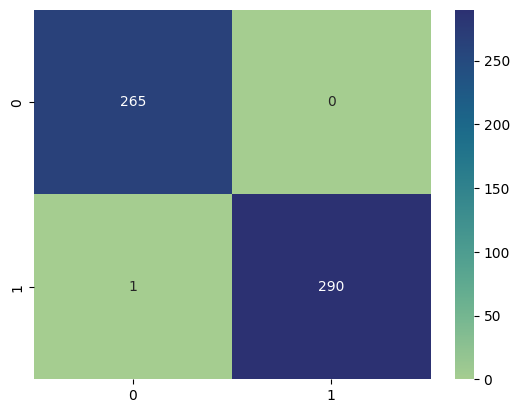

In [27]:
conf_mat = confusion_matrix(pred,y_test)
sns.heatmap(conf_mat,annot=True,fmt = '.0f',cmap='crest')

# Loading test dataset

In [28]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [29]:
test_para = test['text'].tolist()
new_test = []
for entry in test_para:
    char = [char for char in entry if char not in string.punctuation]
    words1test = "".join(char).split()
    words2test = [word.lower() for word in words1test]
    test_stem = [snowball.stem(word) for word in words2test]
    testtext = [ word.lower() for word in test_stem if word not in stopwords.words('english')]
    new_test.append(" ".join(testtext))

In [30]:
new_test

['aaa bbb ccc', 'bbb ccc ddd', 'ccc ddd eee']

In [31]:
for i in range(len(new_test)):
    new_rows.append(new_test[i])

In [32]:
vec = vectorizer.fit_transform(new_rows).toarray()

In [33]:
vec.shape

(2781, 13173)

In [34]:
x_new = vec[0:2778,:]
x_new

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [35]:
x_train1 , x_test1 , y_train1 , y_test1 = train_test_split(x_new,y)

In [36]:
model.fit(x_train1,y_train1)

GradientBoostingClassifier()

<Axes: >

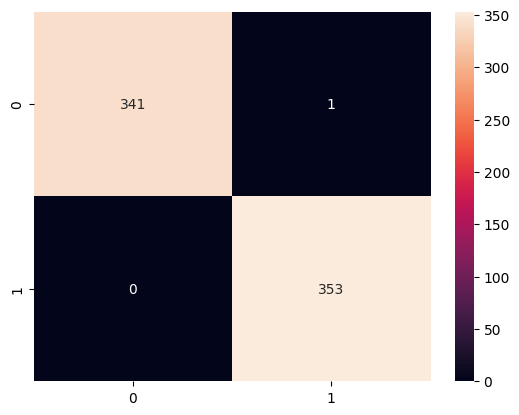

In [37]:
sns.heatmap(confusion_matrix(model.predict(x_test1),y_test1),annot=True,fmt='.0f')

In [38]:
probs = model.predict_proba(vec[2778:,:])
probs

array([[0.1159701, 0.8840299],
       [0.1159701, 0.8840299],
       [0.1159701, 0.8840299]])

In [39]:
result = []
for i in range(len(probs)) :
    result.append(probs[i,0])
result

[0.11597009807029568, 0.11597009807029568, 0.11597009807029568]

In [40]:
result = np.array(result)
result = result.astype('float64')
result

array([0.1159701, 0.1159701, 0.1159701])

In [41]:
submit = pd.DataFrame(test['id'])
submit['generated'] = result
submit

,id,generated
0,0000aaaa,0.11597
1,1111bbbb,0.11597
2,2222cccc,0.11597


In [42]:
submit.to_csv('submission.csv', index=False)